In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, GRU, concatenate, Input
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

In [2]:
# !pip install pmdarima sktime

In [3]:
def get_metrics(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'medAE: {median_absolute_error(y_true, y_pred)}')
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')
    print(f'MSLE: {mean_squared_log_error(y_true, y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')

In [4]:
df = pd.read_csv(open('powerconsumption.csv'))
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [5]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    1
PowerConsumption_Zone3    1
dtype: int64

In [6]:
df = df.dropna().reset_index(drop = True)
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [7]:
batched_df = [df[i:i+12] for i in range(0, len(df), 12)]

averages_df = pd.DataFrame(columns=['PowerConsumption_Zone1'])

for batch in batched_df:
    average_value = batch['PowerConsumption_Zone1'].mean()
    averages_df.loc[len(averages_df)] = [average_value]

print(averages_df)

      PowerConsumption_Zone1
0               26927.594937
1               21447.088607
2               20641.518987
3               20094.683545
4               21255.189873
...                      ...
1056            26830.978725
1057            24234.893617
1058            25206.127660
1059            25499.234043
1060            29420.936169

[1061 rows x 1 columns]


In [8]:
averages_df = averages_df.reset_index(drop = True)
msk = (averages_df.index < len(averages_df) - int(0.2 * len(averages_df)))
df_train = averages_df[msk].copy()
df_test = averages_df[~msk].copy()

<Axes: >

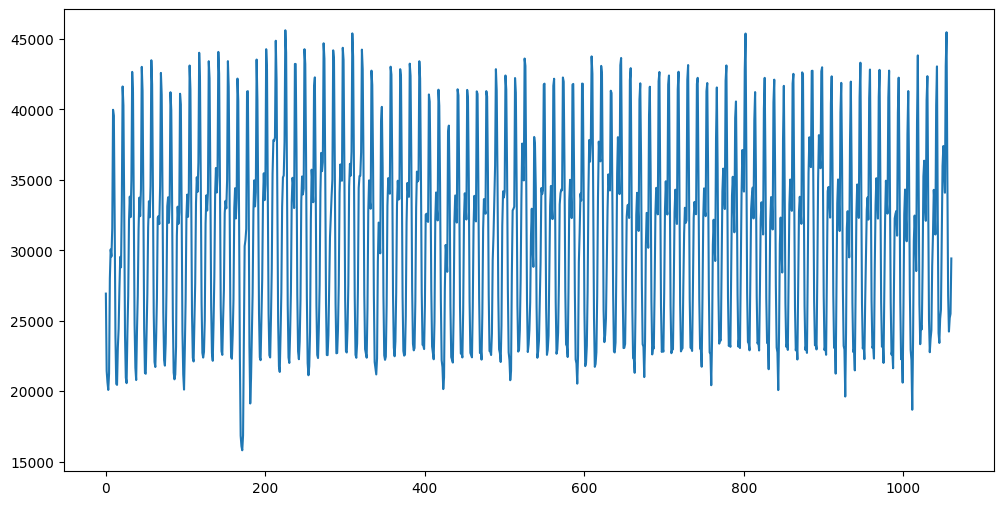

In [9]:
averages_df['PowerConsumption_Zone1'].plot(figsize = (12, 6))

In [10]:
fh = ForecastingHorizon(df_test['PowerConsumption_Zone1'].index, is_relative = False)
fh

ForecastingHorizon([ 849,  850,  851,  852,  853,  854,  855,  856,  857,  858,
       ...
       1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060],
      dtype='int64', length=212, is_relative=False)

MAE: 6096.529907510483
medAE: 5358.638297083335
MSE: 51796329.507433474
MSLE: 0.051450728193402274
MAPE: 0.18955361793362188


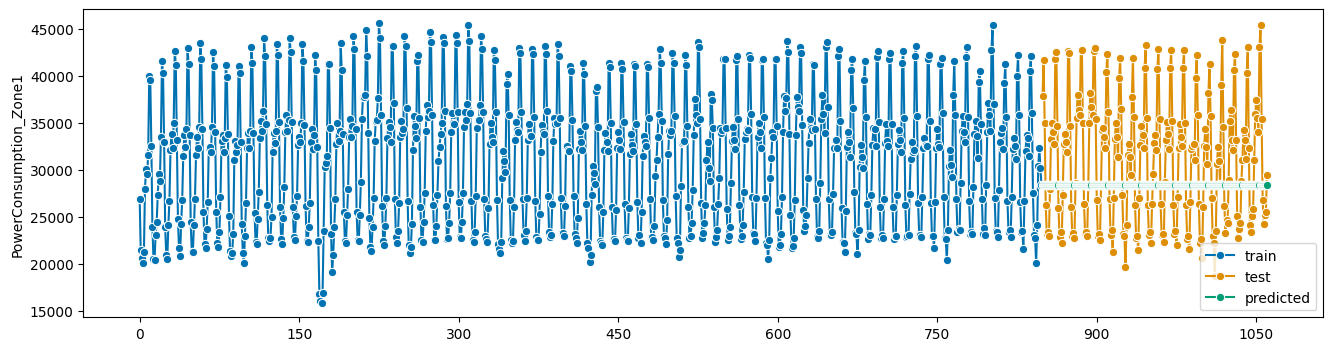

In [11]:
forecaster = NaiveForecaster(strategy = 'last')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 5720.965115470403
medAE: 4921.531915
MSE: 44215989.03260972
MSLE: 0.04687727608464026
MAPE: 0.1932975873549584


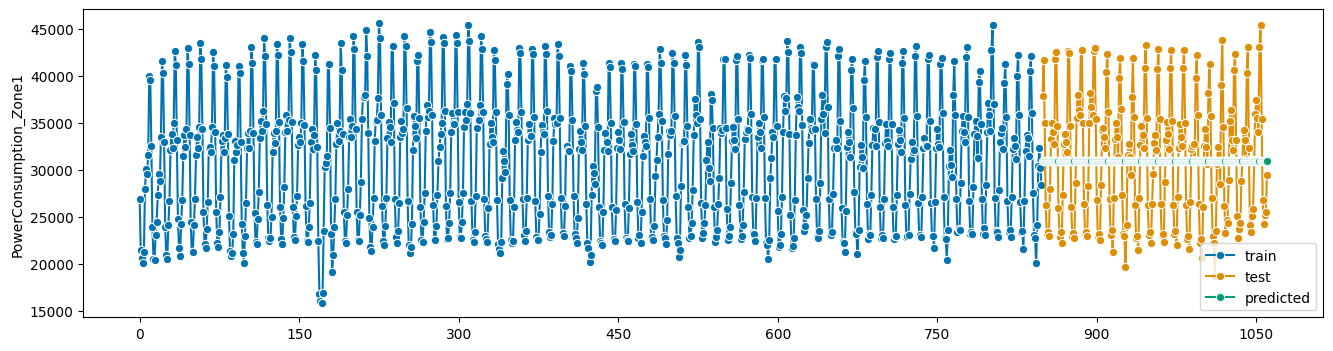

In [12]:
forecaster = NaiveForecaster(strategy = 'mean')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 1631.5336772510482
medAE: 1108.5925004166638
MSE: 4786099.303198604
MSLE: 0.00536276456046328
MAPE: 0.0540970431280468


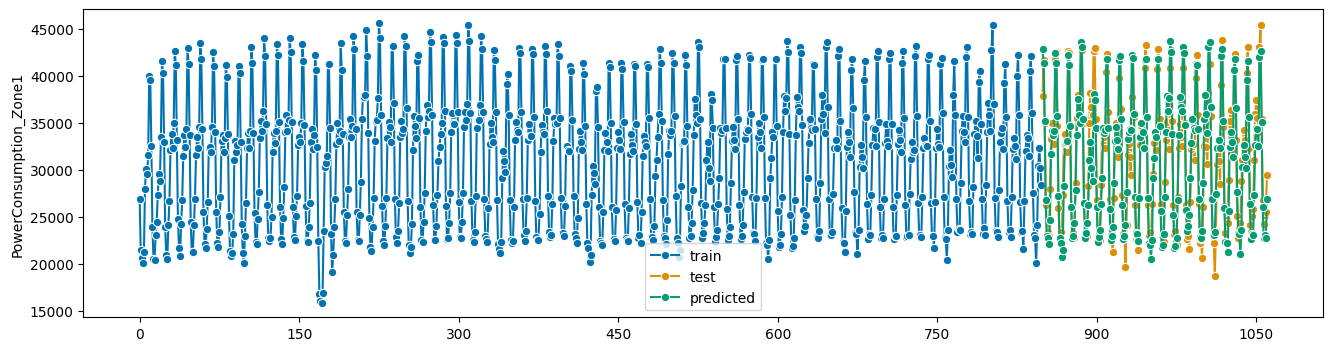

In [13]:
forecaster = NaiveForecaster(strategy = 'last', sp = 30 * 12)
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 896.9433961622113
medAE: 663.8297870833339
MSE: 1494501.889772882
MSLE: 0.0014606966653526495
MAPE: 0.02868173301182632


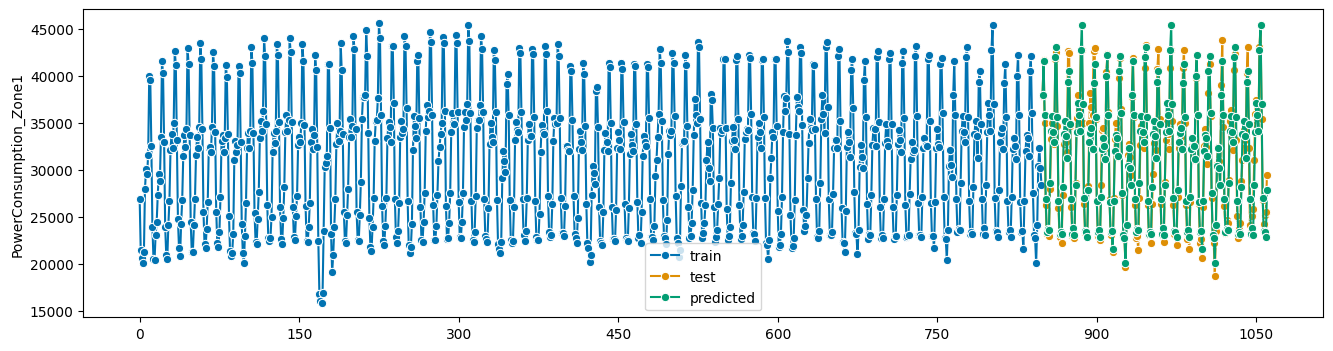

In [14]:
forecaster = NaiveForecaster(strategy = 'last', sp = 7 * 12)
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE: 6094.700185749463
medAE: 5358.638297083335
MSE: 51747732.58051423
MSLE: 0.05140764086899833
MAPE: 0.18954803712226365


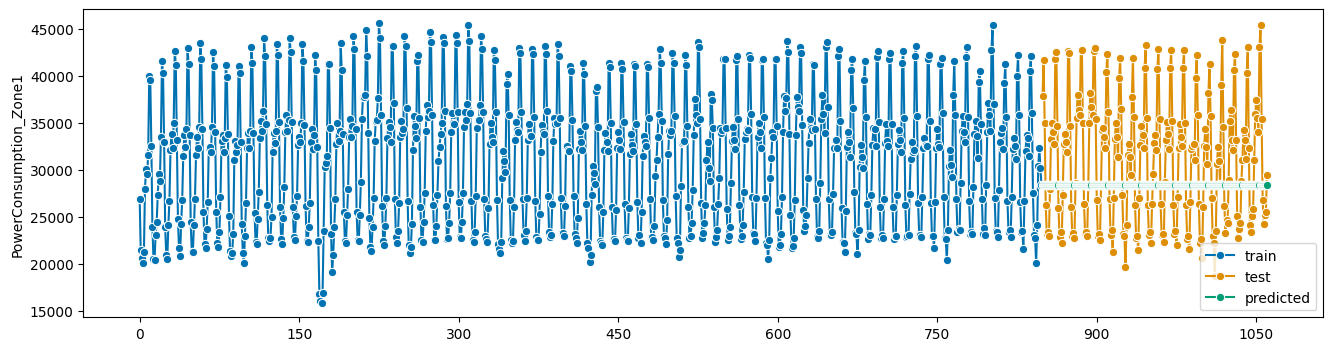

In [15]:
forecaster = ExponentialSmoothing()
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

MAE: 6096.493530197394
medAE: 5358.638297083335
MSE: 51795361.821131505
MSLE: 0.05144986955557257
MAPE: 0.1895535069796362


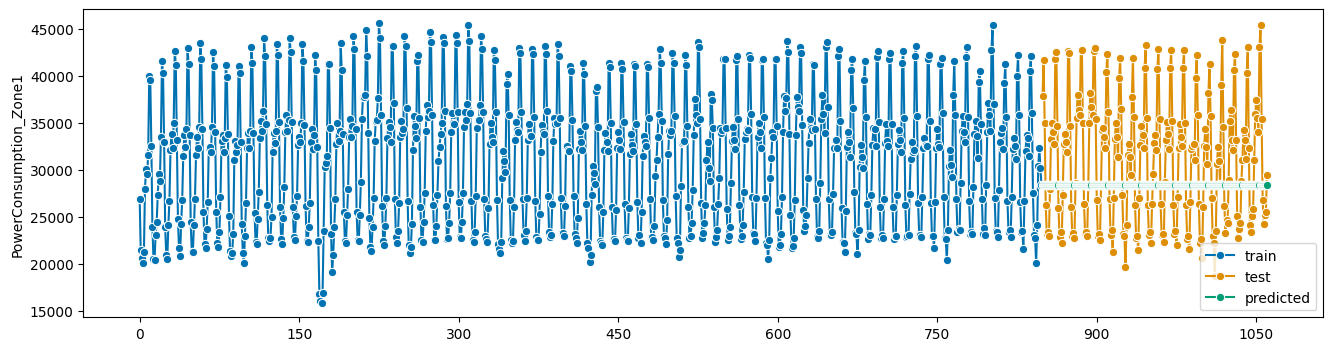

In [16]:
forecaster = AutoETS(auto = True, n_jobs = -1, information_criterion = 'bic')
forecaster.fit(df_train['PowerConsumption_Zone1'])

y_pred = forecaster.predict(fh)

plot_series(df_train['PowerConsumption_Zone1'], df_test['PowerConsumption_Zone1'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['PowerConsumption_Zone1'], y_pred)

In [17]:
forecaster.get_params()

{'additive_only': False,
 'allow_multiplicative_trend': False,
 'auto': True,
 'bounds': None,
 'callback': None,
 'damped_trend': False,
 'dates': None,
 'disp': False,
 'error': 'add',
 'freq': None,
 'full_output': True,
 'ignore_inf_ic': True,
 'information_criterion': 'bic',
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': None,
 'initialization_method': 'estimated',
 'maxiter': 1000,
 'missing': 'none',
 'n_jobs': -1,
 'random_state': None,
 'restrict': True,
 'return_params': False,
 'seasonal': None,
 'sp': 1,
 'start_params': None,
 'trend': None}

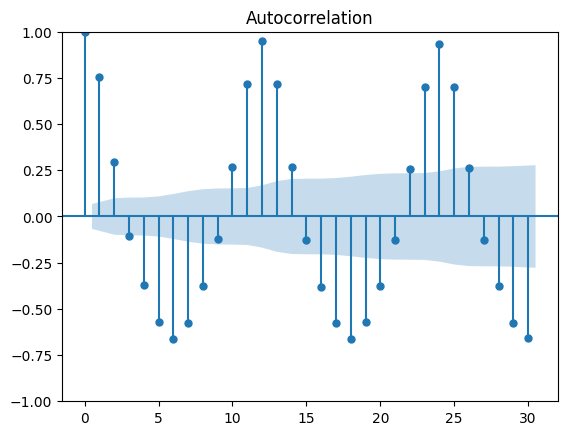

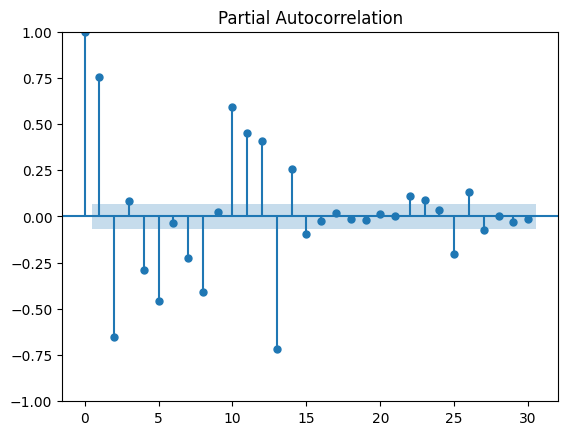

In [18]:
acf_original = plot_acf(df_train['PowerConsumption_Zone1'])
plt.show()

pacf_original = plot_pacf(df_train['PowerConsumption_Zone1'])
plt.show()

In [19]:
adf_test = adfuller(df_train['PowerConsumption_Zone1'])
print(f'p-value: {adf_test[1]}')

p-value: 0.0001685494482965503


In [20]:
seasons = df_train['PowerConsumption_Zone1'][: 12 * 7]
seasons.shape

(84,)

<Axes: >

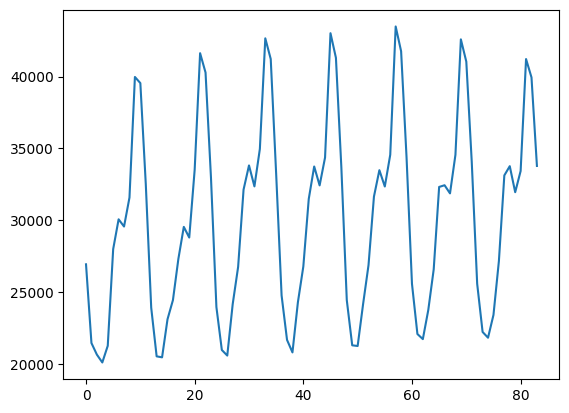

In [21]:
seasons.plot()

In [22]:
adf_test = adfuller(seasons)
print(f'p-value: {adf_test[1]}')

p-value: 0.07978925767152517


In [23]:
seasons = seasons.diff().dropna().reset_index(drop = True)
adf_test = adfuller(seasons)
print(f'p-value: {adf_test[1]}')

p-value: 0.0019183679901584683


<Axes: >

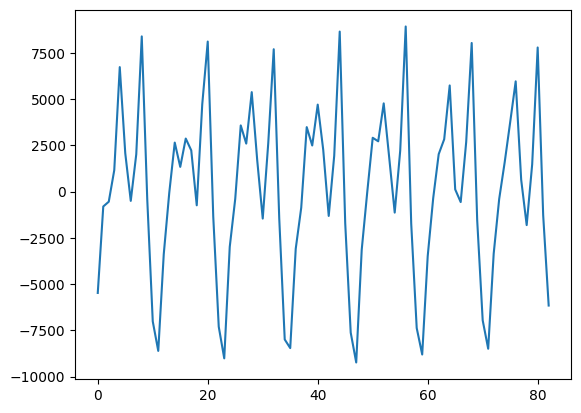

In [24]:
seasons.plot()

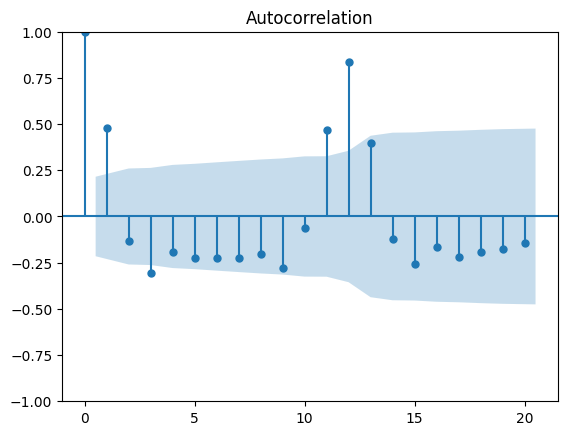

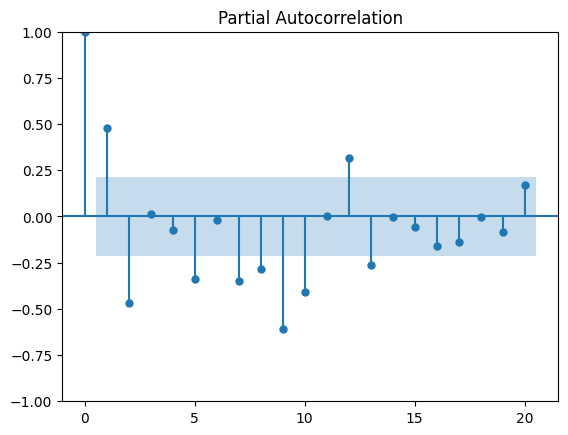

In [25]:
acf_original = plot_acf(seasons)
plt.show()

pacf_original = plot_pacf(seasons)
plt.show()

In [ ]:
model = ARIMA(df_train['PowerConsumption_Zone1'], order = (2, 0, 2), seasonal_order = (1, 1, 2, 7 * 12))
model_fit = model.fit()
print(model_fit.summary())